# Аналитика мобильной игры

В компании по разработке мобильных игр хотят оценить некоторые показатели новой игры.\
**Задача.** Написать функцию, расчитывающую retention и оценить результаты А/В теста.

In [4]:
import pandas as pd
import datetime as dt
from datetime import timedelta
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from tqdm.auto import tqdm
from scipy.stats import norm

In [13]:
df_reg = pd.read_csv('/Users/kristinasharoyko/Documents/data_for/archive/problem1-reg_data.csv', sep = ';')
df_auth = pd.read_csv('/Users/kristinasharoyko/Documents/data_for/archive/problem1-auth_data.csv', sep = ';')

### Обзор данных

In [14]:
df_reg.head()

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5


In [15]:
df_auth.head()

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2


In [16]:
df_reg.dtypes

reg_ts    int64
uid       int64
dtype: object

In [17]:
df_auth.dtypes

auth_ts    int64
uid        int64
dtype: object

In [18]:
df_reg.isna().sum()

reg_ts    0
uid       0
dtype: int64

In [19]:
df_auth.isna().sum()

auth_ts    0
uid        0
dtype: int64

In [20]:
df_reg.shape

(1000000, 2)

In [21]:
df_auth.shape

(9601013, 2)

В данных нет пропусков, все значения числовые, можно делать дальше функцию расчета retention.\
\
В функцию задаем df с датой регистрации и заходов пользователей соответственно **df_reg** и **df_auth** (по умолчанию вышезагруженные df)\
**reg_YYYY_MM_DD** - дата регистрации в формате год-месяц-день(по умолчанию берем регистрации за последние 30 дней)\
**end_YYYY_MM_DD** - до какой даты брать данные об авторизации в формате год-месяц-день(по умолчанию последний день данных)\

In [13]:
def retention(df_reg = df_reg, df_auth = df_auth, reg_YYYY_MM_DD = None, end_YYYY_MM_DD = None):
    
    #переведем unix-время в удобную дату, запишем в новый столбец
    df_reg['reg_days'] = pd.to_datetime(df_reg['reg_ts'], unit = 's').round('d')
    df_auth['auth_days'] = pd.to_datetime(df_auth['auth_ts'], unit = 's').round('d')
    
    #если не указан период регистраций записываем последний месяц
    if reg_YYYY_MM_DD is None:
        reg_YYYY_MM_DD = df_reg['reg_days'].max() - timedelta(days=30)
    else:
        reg_YYYY_MM_DD = dt.datetime.strptime(reg_YYYY_MM_DD, '%Y-%m-%d')
    
    #если не указан период авторизаций записываем последнюю дату в данных
    if end_YYYY_MM_DD is None:
        end_YYYY_MM_DD = df_auth['auth_days'].max()
    else:
        end_YYYY_MM_DD = dt.datetime.strptime(end_YYYY_MM_DD, '%Y-%m-%d')
    
    #выбираем данные по заданному периоду
    reg_df = df_reg.query("reg_days>= @reg_YYYY_MM_DD").drop(columns= ['reg_ts'])
    auth_df = df_auth.query("auth_days<= @end_YYYY_MM_DD").drop(columns= ['auth_ts'])
    
    #соединяем две таблицы с датой регистрации и авторизациями
    df_total = pd.merge(reg_df, auth_df, on = 'uid', how = 'inner')
    
    #вычислим количество дней между регистрацией и заходами в игру
    df_total['days'] = (df_total['auth_days'] - df_total['reg_days']).dt.days
    
    #сводная таблица с когортами
    df_pivot = df_total.groupby(['reg_days', 'days']).nunique('uid').reset_index()
    df_cohort = df_pivot.pivot(index='reg_days', columns='days', values='uid')
    
    #считаем retention
    df_retention = df_cohort.div(df_cohort[0], axis=0).round(2)
    
    #график retention
    plt.rcParams['font.size'] = '12'
    plt.figure(figsize=(20,15))
    plt.title('Retention')
    ax = sns.heatmap(data=df_retention, annot=True, vmin=0.0 , vmax=0.08, fmt='.0%' )
    ax.set_yticklabels(df_retention.index.astype('str'))
    fig=ax.get_figure()

    plt.show()

    return 
    

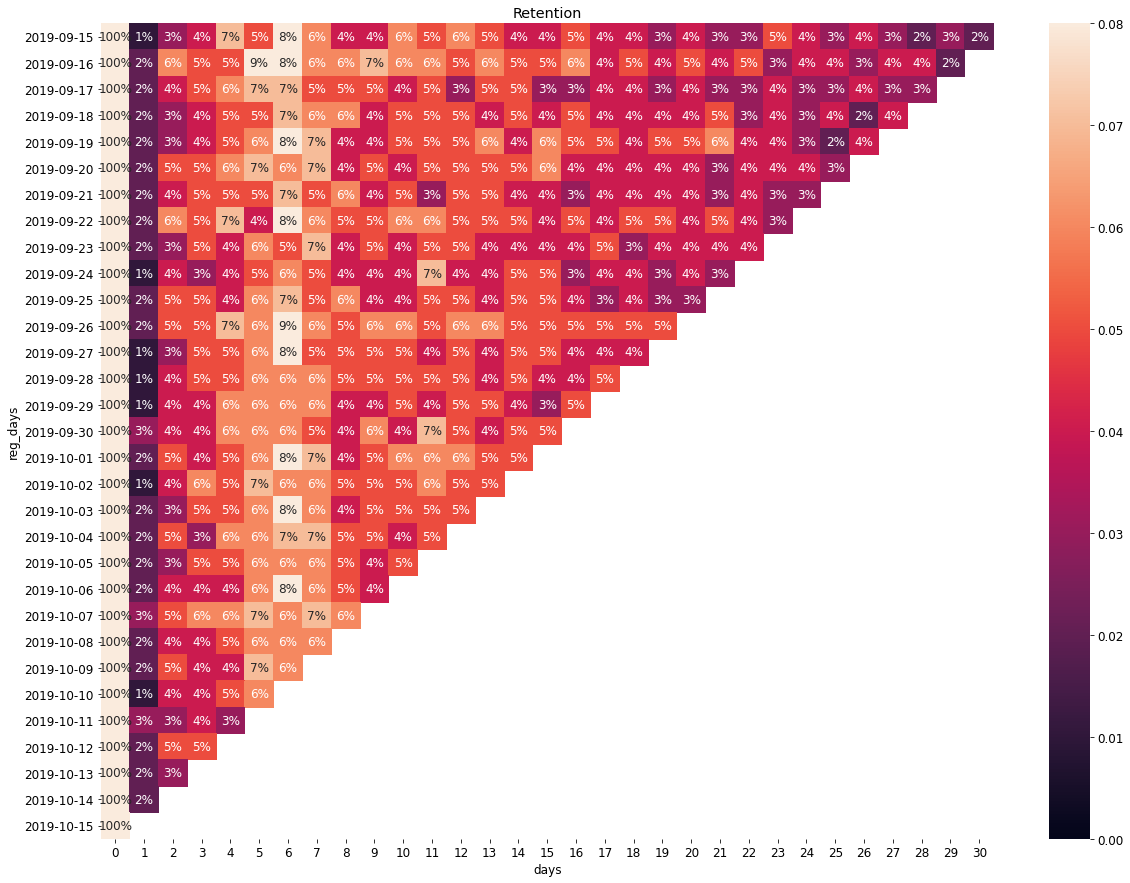

In [14]:
retention(df_reg, df_auth, '2019-09-15', '2019-10-15')

#### Вывод: 
Видно, что во второй день установки заходит минимальное количество пользователей, в то время как на 6 день к игре максимальный интерес, который после постпенно уменьшается. Возможно, на шеcтой день есть какое-то побуждающее действие(например, push-уведомление) и если мы добавим его на второй день, количество заходов в игру станет больше, это можно/нужно проверить.

### Анализ результатов А/В теста

Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений.\
Нужно определить, какой набор предложений лучше и какие метрики лучше использовать для принятия правильного решения.

In [22]:
df = pd.read_csv('/Users/kristinasharoyko/Documents/data_for/archive/Проект_1_Задание_2.csv', sep = ';')
df.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


In [31]:
# пропущенных нет
df.isna().sum()

user_id      0
revenue      0
testgroup    0
dtype: int64

In [32]:
df.groupby('testgroup')['revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
testgroup,,,,,,,,
a,202103.0,25.413720,920.768137,0.0,0.0,0.0,0.0,37433.0
b,202667.0,26.751287,287.324162,0.0,0.0,0.0,0.0,4000.0


Выше видим, что в контрольной группе намного выше максимальное revenue и стандартное отклонение\
Разделим данные на две группы, посмотрим нормальность изначальных данных

In [33]:
control = df.query("testgroup == 'a'")['revenue']
test = df.query("testgroup == 'b'")['revenue']

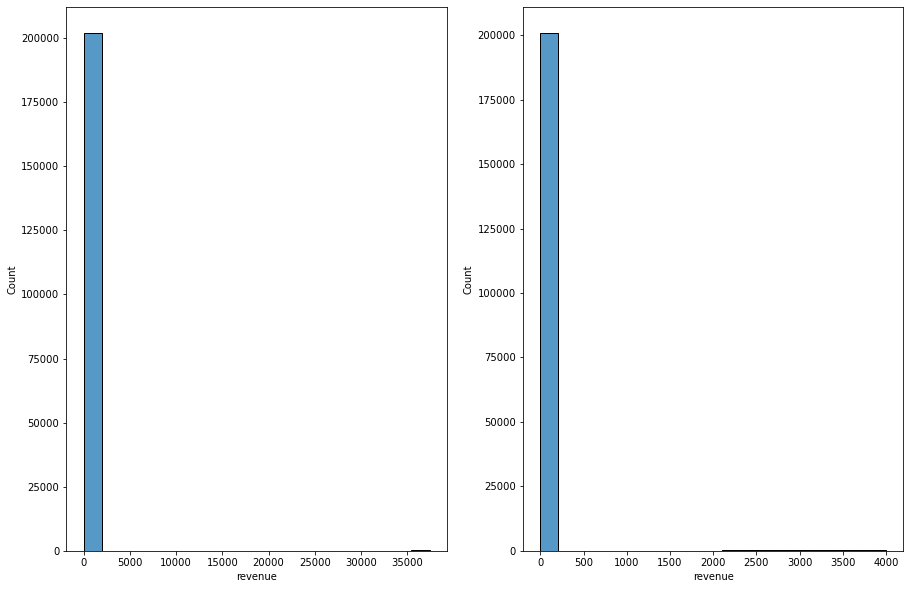

In [34]:
fig, ax = plt.subplots(1,2, figsize=(15, 10))
sns.histplot(control, ax=ax[0])
sns.histplot(test, ax=ax[1])
plt.show()

По графикам все распределено ненормально, потому что огромный пик с нулевыми покупками

In [35]:
#посмотрим, что будет если оставить только платящих пользователей
df_1 = df.query("revenue > 0")
df_1.head()

,user_id,revenue,testgroup
72,73,351,a
160,161,3797,b
341,342,290,a
377,378,3768,b
385,386,250,a


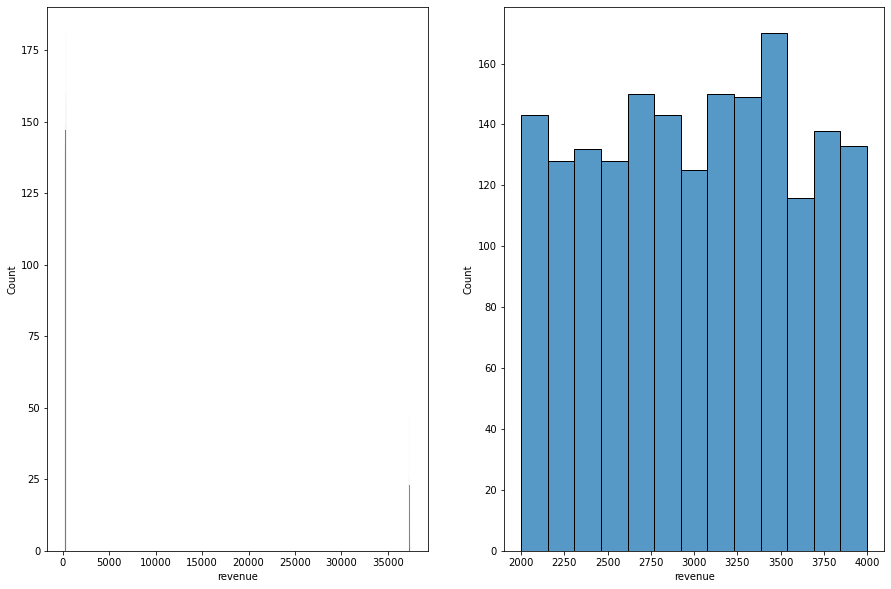

In [36]:
fig, ax = plt.subplots(1,2, figsize=(15, 10))
sns.histplot(df_1[df_1['testgroup']=='a']['revenue'], ax=ax[0])
sns.histplot(df_1[df_1['testgroup']=='b']['revenue'], ax=ax[1])
plt.show()

Cохраняется огромная разница в контрольной группе между мин и макс выручкой и различие с тестовой группой, посмотрим хвост контрольной группы

In [37]:
df_1.groupby('testgroup').revenue.describe()

,count,mean,std,min,25%,50%,75%,max
testgroup,,,,,,,,
a,1928.0,2663.998444,9049.039763,200.0,257.0,311.0,361.0,37433.0
b,1805.0,3003.658172,572.619709,2000.0,2513.0,3022.0,3478.0,4000.0


Получается, есть 123 человека в контрольной группе, которые платят более 37000, это либо некорректные данные, либо эти клиенты случайно попали в группу контроля, то есть проблемы с системой сплитования, либо что-то еще

In [38]:
df_1.query("revenue>4000").sort_values('revenue')

,user_id,revenue,testgroup
19495,19496,37293,a
81477,81478,37294,a
235858,235859,37294,a
254113,254114,37294,a
34534,34535,37294,a
...,...,...,...
142804,142805,37379,a
21585,21586,37385,a
65077,65078,37394,a
196601,196602,37407,a


Примем, что данные верные и распределены ненормально, так как огромное количество неплатящих клиентов

In [39]:
#будем использовать бустреп
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_1), 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1)-statistic(samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

  0%|          | 0/1000 [00:00<?, ?it/s]

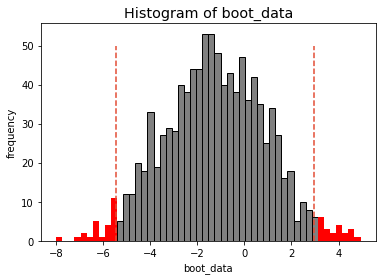

0.5594265162486346

In [40]:
get_bootstrap(control, test)['p_value']

Бустреп показывает, что нет различий средних(то есть ARPU) полученных выборок. Посчитаем ARPPU

In [42]:
dfa = df_1.query("testgroup == 'a'")['revenue']
dfb = df_1.query("testgroup == 'b'")['revenue']

  0%|          | 0/1000 [00:00<?, ?it/s]

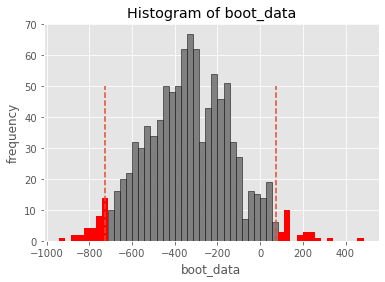

0.10706860974433884

In [43]:
get_bootstrap(dfa, dfb)['p_value']

Между ARPPU тоже нет значимых различий, при этом 85% выручки в контрольной группе связана с суперплатящими клиентами

In [46]:
df_1.groupby('testgroup')['revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
testgroup,,,,,,,,
a,1928.0,2663.998444,9049.039763,200.0,257.0,311.0,361.0,37433.0
b,1805.0,3003.658172,572.619709,2000.0,2513.0,3022.0,3478.0,4000.0


Чаще покупали в контрольной группе

In [47]:
СR = round(df_1.groupby('testgroup')['revenue'].describe()['count'] / df.groupby('testgroup')['revenue'].describe()['count']*100, 2)
СR

testgroup
a    0.95
b    0.89
Name: count, dtype: float64

Процент выручки суперплатящих клиентов

In [48]:
df_1.query("revenue>4000")['revenue'].sum() / df_1.query("testgroup>'a'")['revenue'].sum() * 100

84.66595580679737

### Вывод:
По итогу в текущих выборках нет значимых различий в ARPU и ARPPU, в контрольной группе есть 123 супер клиента, которые дают 85% выручки контрольной группе. Нужно понять, связано ли это с акционными предложениями или с нарушениями в формировании выборок. Если проблема в сплитовании, убрать эти "выбросы" и проверить снова. Также можно следить за СR и ARPPU вместо ARPU, добавить признак привлекли ли мы акцией нового клиента или старого. Сейчас можно только сказать, что по тестам не стоит раскатывать тестовые акции на всю аудиторию, а лучше разобраться с корректностью сбора данных